**Simple Regression ML**

The purpose of the notebook is to show how to use machine learning algortihms in a regression. I will use very simple dataset called california housing. Problem is not very difficult. Data is quite clean and I think EDA and feature engineering will not largely improve the performance of the models. That is why the purpose of the notebook is just to use basic EDA and fastly move to training models. I will try to show very simple models and then a little more complex. However I will not use extremely complex models like neural networks or boosting. Probably they can achive better result but I want to stay with a simple approach.

In [147]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.svm import SVR, LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns

plt.style.use('seaborn')

### Fetching data

In [75]:
housing = fetch_california_housing()
data = pd.DataFrame(housing.data, columns=housing.feature_names)
data['Price'] = housing.target
print('Number of rows: ', data.shape[0])
print('Number of columns: ', data.shape[1])
data.head()

Number of rows:  20640
Number of columns:  9


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Price
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


The california housing dataset is extremely popular yet very simple. It is relatively outdated so the model will be not very useful in predicting data nowadays. The purpose is very simple. We would like to predict price of a houses in districts basing on its characteristics like:
* MedInc - median income
* HouseAge - mean house age
* AveRooms - average rooms in a house
* AveBedrms - average bedrooms in a house
* Population - population in a district
* AveOccup - number of inhabitants
* Latitude and Longitude - localisation of a district.

Obviously it is a regression learning. First of all we need to check whether there are any null values.

In [76]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
 8   Price       20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


There are no null values. Lets split data and use only train dataset.

In [77]:
train_df, test_df = train_test_split(data, random_state=42, test_size=0.2)

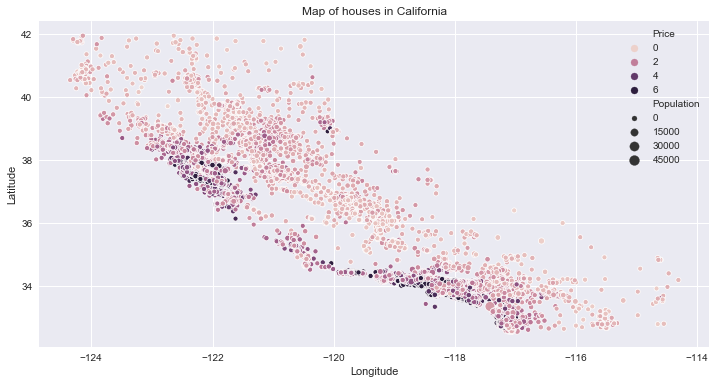

In [78]:
fig, ax = plt.subplots(figsize=(12,6))
sns.scatterplot(x='Longitude', y='Latitude', size='Population', 
                hue='Price', data=train_df, ax=ax)
ax.set_title('Map of houses in California');

First of all it seems that houses close to sea are more expensive than inland houses.  Additionally it seems that houses close to San Francisco and Los Angeles are much more expensive. It is not suprising since houses in big cities tend to be expensive.

Text(0.5, 1.0, 'Relationship between Median Income and Price')

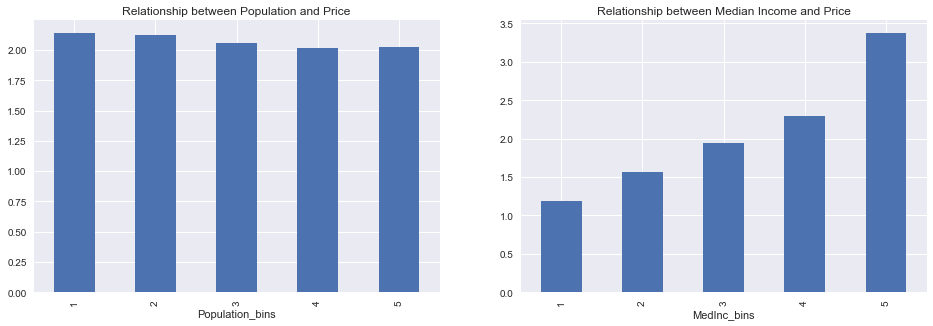

In [79]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

temp = train_df.copy()
temp['Population_bins'] = pd.qcut(temp['Population'], q=5, labels=list(range(1,6)))
temp.groupby('Population_bins')['Price'].mean().plot(kind='bar', ax=axes[0])
axes[0].set_title('Relationship between Population and Price')

temp['MedInc_bins'] = pd.qcut(temp['MedInc'], q=5, labels=list(range(1,6)))
temp.groupby('MedInc_bins')['Price'].mean().plot(kind='bar', ax=axes[1])
axes[1].set_title('Relationship between Median Income and Price')

Population is not really correlated with prices. Quite often big cities are tend to be really expansive but not in this case. Probably localisation is much more important. People prefer to live close to the sea in a rich neighborhood. As we saw in a previous chart localisation was very important. Looking at the bar chart comparing median income and prices it seems obvious that rich areas tend to be really expansive. If you have Hollywood star as your neighbour you have to be rich too and you can buy expansive house then.

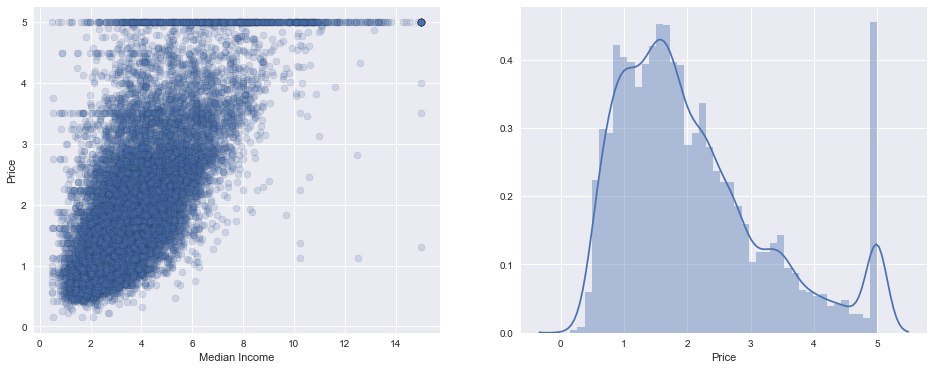

In [80]:
fig, ax = plt.subplots(1, 2, figsize=(16,6))
ax[0].scatter(train_df['MedInc'], train_df['Price'], alpha=0.2, edgecolor='black')
ax[0].set_ylabel('Price')
ax[0].set_xlabel('Median Income')
sns.distplot(train_df['Price'], hist=True, ax=ax[1]);

If you earn more then you pay more for houses. It is seems that there are no prices higher than 5. According to documentation there is a cut-off. Probably it would be good to remove value 5 before feeding machine learning algorithms.

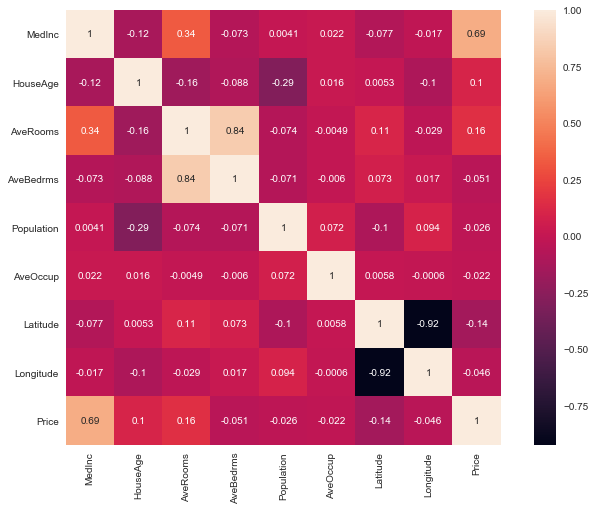

In [81]:
corr_mat = train_df.corr()
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(corr_mat, annot=True, square=True, ax=ax)

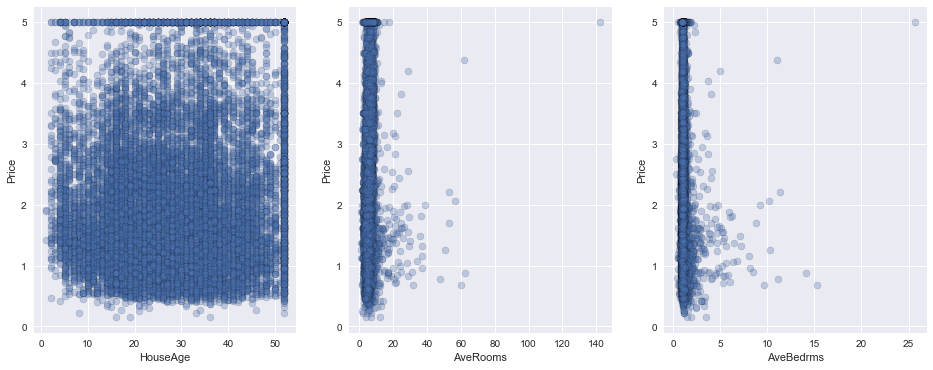

In [82]:
fig, axes = plt.subplots(1, 3, figsize=(16, 6))
columns = ['HouseAge', 'AveRooms', 'AveBedrms']
for i, ax in enumerate(axes):
    col = columns[i]
    ax.scatter(train_df[col], train_df['Price'], alpha=0.3, edgecolor='black')
    ax.set_ylabel('Price')
    ax.set_xlabel(col)

Looking at the charts it is clear that none of 3 features (HouseAge, AveRooms, AveBedrms) is correlated with a target. It does not mean they are useless. Probably relationship is much more complex. It is possible that using other features can show interesting relations which are not visible now. If we had a lot of features it would be a good idea to eliminated those that are not correlated with targets but if we hade only a few features it would be wasteful. That why I will use all features although most of them are probably not extremely useful.

### Machine Learning

In [83]:
X_train = train_df.drop(columns='Price')
Y_train = train_df['Price']

X_test = test_df.drop(columns='Price')
Y_test = test_df['Price']

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [101]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score, cross_val_predict

In [141]:
ridge_pipeline = make_pipeline(PolynomialFeatures(degree=2), RidgeCV(alphas=[300, 350, 400, 450, 500]))
score = cross_val_score(ridge_pipeline, X_train, Y_train, scoring='neg_mean_squared_error')
np.mean(np.abs(score))

0.5050023788701848

In [148]:
ridge_pred = cross_val_predict(ridge_pipeline, X_train, Y_train)
ridge_pred[ridge_pred < 0] = 0
ridge_mse = mean_squared_error(Y_train, ridge_pred)
ridge_r2 = r2_score(Y_train, ridge_pred)
ridge_pipeline.fit(X_train, Y_train)
ridge_alpha = ridge_pipeline.get_params()['ridgecv'].alpha_

print(f'Best result is with Ridge Regession with alpha {ridge_alpha}')
print(f'Mean squared error is {ridge_mse.round(4)} and r2_score {ridge_r2.round(4)}')

Best result is with Ridge Regession with alpha 400
Mean squared error is 0.4998 and r2_score 0.6261


(0, 5)

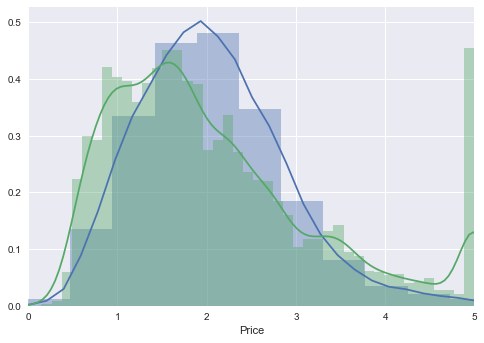

In [152]:
sns.distplot(ridge_pred)
sns.distplot(Y_train)
ax = plt.gca()
ax.set_xlim(0,5)

In [61]:
forest_params = {'n_estimators': [100, 200, 500], 'max_depth': [5, 10, 30], 'verbose': [1]}
forest_model = RandomForestRegressor()
forest_cv = GridSearchCV(forest_model, param_grid=forest_params, cv=5)
forest_cv.fit(X_train, Y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   56.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   55.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   54.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   16.4s finished
[Parallel(n_jobs=1)]: Us

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [90]:
random_forest = forest_cv.best_estimator_
Y_pred = random_forest.predict(X_train)
np.corrcoef(Y_pred, Y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.6s finished


array([[1.        , 0.98836537],
       [0.98836537, 1.        ]])

In [133]:
Y_pred = random_forest.predict(X_test)
mse = mean_squared_error(Y_test, Y_pred)
mse

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.2s finished


0.25400602061040667

In [131]:
r2_score(Y_test, Y_pred)

0.8061627897640127

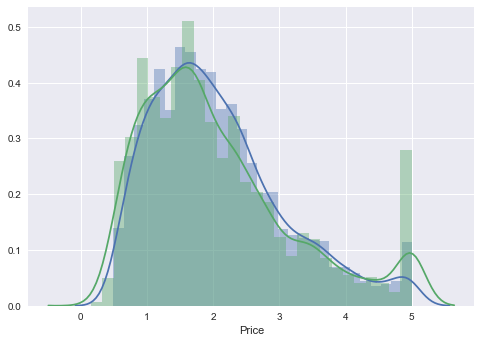

In [130]:
sns.distplot(Y_pred)
sns.distplot(Y_test)

In [97]:
r2_score(Y_test, Y_pred)

0.8061627897640127

In [22]:
svm_params = {'kernel': ('linear', 'rbf'), 'C': (0.1, 1, 10), 'gamma': ('auto',)}
svr = SVR()
grid_search = GridSearchCV(svr, param_grid=svm_params, cv=5)

In [23]:
grid_search.fit(X_train, Y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': (0.1, 1, 10), 'gamma': ('auto',),
                         'kernel': ('linear', 'rbf')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [31]:
model = grid_search.best_estimator_

In [54]:
Y = Y_train.values.reshape(-1,1)

Y_pred = model.predict(X_train)

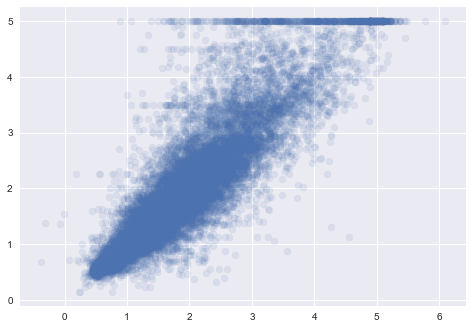

In [55]:
plt.scatter(Y_pred, Y_train, alpha=0.1)

In [40]:
np.corrcoef(Y_pred, Y_train)

array([[1.        , 0.88513518],
       [0.88513518, 1.        ]])

In [69]:
X_test = imputer.transform(X_test)
X_test = scaler.transform(X_test)

In [70]:
Y_pred = model.predict(X_test)

In [65]:
from sklearn.metrics import mean_squared_error

In [65]:
mse = mean_squared_error(Y_test, Y_pred)

In [66]:
np.sqrt(mse)

1.3904147954507688

In [67]:
np.mean(Y_test), np.std(Y_test)

(2.0550030959302275, 1.144730963257702)

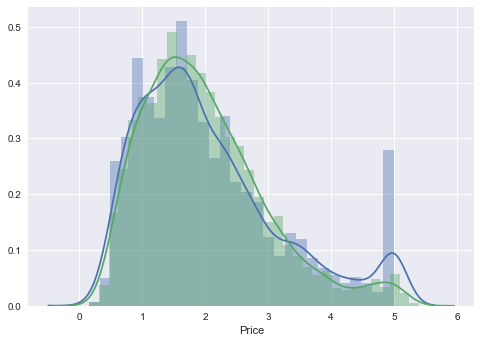

In [71]:
sns.distplot(Y_test)
sns.distplot(Y_pred)